In [1]:
import matplotlib.pyplot as plot
import igraph

In [2]:
def is_reaction(string):
    return string.startswith("REACTION")

metabolites = set()
reactions = set()
edges = {}

In [3]:
graph = igraph.Graph(directed=True)

f = open("hsmetnet.txt", "r")

for line in f:
    for item in line.strip().split("\t"):
        if is_reaction(item):
            reactions.add(item)
        else:
            metabolites.add(item)
              
for metabolite in metabolites:
    graph.add_vertex(name=metabolite, type=False)
    
for reaction in reactions:
    graph.add_vertex(name=reaction, type=True)
                
f.seek(0) # and ye shall find
edges_set = set()

for line in f:
    first, second = line.strip().split("\t")
    edges_set.add((first, second))
    
    if first in edges:
        edges[first].append(second)
    else:
        edges[first] = [second]
        
graph.add_edges(edges_set)
del edges_set

f.close()

print("Number of metabolites:", len(metabolites))
print("Number of reactions:", len(reactions))
print("Total number of vertices:", len(metabolites) + len(reactions))
print()

original_graph = graph
del graph

print(original_graph.summary())
print("Bipartite:", original_graph.is_bipartite())

Number of metabolites: 2340
Number of reactions: 5539
Total number of vertices: 7879

IGRAPH DN-T 7879 19537 -- 
+ attr: name (v), type (v)
Bipartite: True


In [4]:
def collapse(graph, t):
    collapsed_graph = igraph.Graph(directed=graph.is_directed())
    original_vertices = graph.vs.select(type=t)
    
    for vertex in original_vertices:
        try:
            collapsed_graph.add_vertex(vertex["name"], label=vertex["label"])
        except KeyError:
            collapsed_graph.add_vertex(vertex["name"])
        
    for vertex1 in original_vertices:
        for neighbor in vertex1.neighbors(mode=igraph.OUT):
            for vertex2 in neighbor.neighbors(mode=igraph.OUT):
                collapsed_graph.add_edge(vertex1["name"], vertex2["name"])
                
    return collapsed_graph

In [5]:
collapsed_graph = collapse(original_graph, False)
print(collapsed_graph.summary())
print("Bipartite:", collapsed_graph.is_bipartite())

IGRAPH DN-- 2340 18078 -- 
+ attr: name (v)
Bipartite: False


In [6]:
print("Number of metabolites:", len(metabolites))
print("Vertices in compressed graph:", collapsed_graph.vcount())
print()

Number of metabolites: 2340
Vertices in compressed graph: 2340



In [7]:
distances = []

for vertex in original_graph.vs:
    distances.append([i for i in vertex.shortest_paths()[0] if i not in (float("inf"), 0)])
    
og_longest_geodesic_path = max([max(i) for i in distances if len(i) > 0])



distances = []

for vertex in collapsed_graph.vs:
    distances.append([i for i in vertex.shortest_paths()[0] if i not in (float("inf"), 0)])
    
cg_longest_geodesic_path = max([max(i) for i in distances if len(i) > 0])

del distances

In [8]:
og = [original_graph.average_path_length(), og_longest_geodesic_path]
cg = [collapsed_graph.average_path_length(), cg_longest_geodesic_path]

print(og)
print(cg)

[7.958659055333345, 32]
[4.807637629882836, 16]


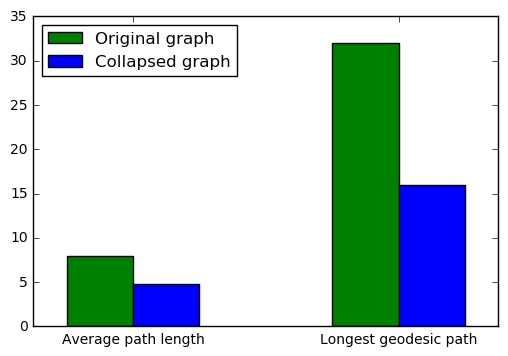

In [9]:
multiple_bars = plot.figure()

x = range(1, 4, 2)

ax = plot.subplot(111)
ax.bar(x,                  og,width=0.5,color='g',align='center', label="Original graph")
ax.bar([i+0.5 for i in x], cg,width=0.5,color='b',align='center', label="Collapsed graph")


plot.xticks([i + .25 for i in x], ('Average path length', 'Longest geodesic path', 'C', 'D'))
plot.legend(loc="upper left")
plot.show()

Original graph: 7879 19537
Reduced graph:  2340 18078
Vertex net change: -70.30079959385709
Edge net change: -7.467881455699442


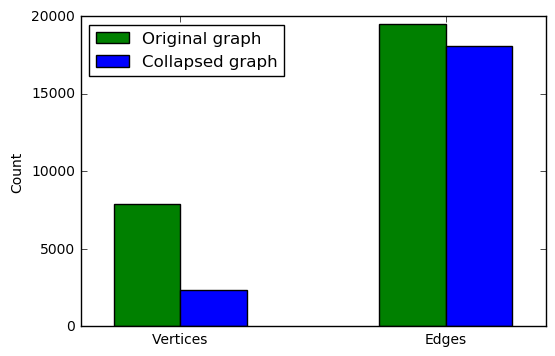

In [10]:
multiple_bars = plot.figure()

x = range(1, 4, 2)

print("Original graph:", original_graph.vcount(), original_graph.ecount())
print("Reduced graph: ", collapsed_graph.vcount(), collapsed_graph.ecount())
print("Vertex net change:", (collapsed_graph.vcount()-original_graph.vcount())/original_graph.vcount()*100)
print("Edge net change:", (collapsed_graph.ecount()-original_graph.ecount())/original_graph.ecount()*100)

ax = plot.subplot(111)
ax.bar(x,                  [original_graph.vcount(), original_graph.ecount()],width=0.5,color='g',align='center', label="Original graph")
ax.bar([i+0.5 for i in x], [collapsed_graph.vcount(), collapsed_graph.ecount()],width=0.5,color='b',align='center', label="Collapsed graph")

plot.ylabel("Count")
plot.xticks([i + .25 for i in x], ('Vertices', 'Edges', 'C', 'D'))
plot.legend(loc="upper left")
plot.show()

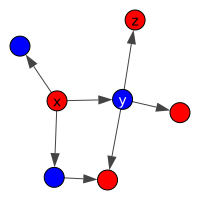

In [11]:
example = igraph.Graph(directed=True)
count = 0
for vertex in ["x", "y", "z", "p", "q", "r", "s"]:
    example.add_vertex(name=vertex, 
                       label=(vertex if vertex in ("x", "y", "z") else None),
                       #label=vertex,
                       type=count%2, 
                       color=("blue" if count%2 else "red"), 
                       label_color=("white" if count%2 else "black"))
    count += 1
#example.add_vertices(["x", "y", "z", "p", "q", "r", "s"])
example.add_edges([('x', 'y'), ('y', 'z'), ('x', 'r'), ('x', 'p'), ('y', 's'), ('y', 'q'), ('p', 's')])

igraph.drawing.plot(example, bbox=(200, 200), target="output.pdf")

IGRAPH DN-T 7 7 -- 
+ attr: color (v), label (v), label_color (v), name (v), type (v)
Bipartite: True
0 x
1 y
2 z
3 p
4 q
5 r
6 s

IGRAPH DN-- 4 4 -- 
+ attr: label (v), name (v)


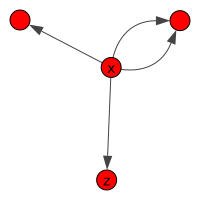

In [12]:
print(example.summary())
print("Bipartite:", example.is_bipartite())

for v in example.vs:
    print(v.index, v["name"])
print()

collapsed_example = collapse(example, False)
print(collapsed_example.summary())
igraph.drawing.plot(collapsed_example, bbox=(200, 200), target="output2.pdf")

In [13]:
def find_motifs(graph):
    motifs = {}
    vertex_sets = set()

    for first in graph.vs:    
        for second in first.neighbors():
            for third in second.neighbors():
                if third in (first, second):
                    continue # Ignore graphs with only two vertices

                vertex_set = frozenset((first, second, third))
                if vertex_set in vertex_sets:
                    continue # Ignore graphs if we've already seen these three vertices before
                else:
                    vertex_sets.add(vertex_set)

                g = graph.subgraph([first, second, third])
                #print(g.summary())
                motif = frozenset({e.tuple for e in g.es})
                #print(motif)
                motifs[motif] = motifs.get(motif, 0) + 1
                
    return motifs

In [14]:
import timeit

start_time = timeit.default_timer()
motifs = find_motifs(original_graph)
ci_elapsed = timeit.default_timer() - start_time

for motif in motifs:
    print("   ", str(motif)[11:-2].replace("),", "**").replace(", ", " -> ").replace("**", "),"), "occurs", motifs[motif], "times in this graph.")
print("    All other triple motifs appear 0 times in this graph.")
print()
print("Elapsed time:", ci_elapsed)

    (0 -> 1), (2 -> 0), (1 -> 0) occurs 3884 times in this graph.
    (0 -> 1), (2 -> 0), (0 -> 2) occurs 409 times in this graph.
    (1 -> 0), (0 -> 2) occurs 121870 times in this graph.
    (0 -> 1), (0 -> 2) occurs 928939 times in this graph.
    (0 -> 2), (2 -> 1) occurs 9807 times in this graph.
    (2 -> 0), (0 -> 2), (2 -> 1) occurs 22 times in this graph.
    (1 -> 2), (2 -> 0), (2 -> 1) occurs 17 times in this graph.
    (1 -> 2), (2 -> 0), (0 -> 2) occurs 2 times in this graph.
    (2 -> 0), (2 -> 1) occurs 5392 times in this graph.
    (2 -> 0), (1 -> 0), (0 -> 2) occurs 3638 times in this graph.
    (0 -> 1), (2 -> 0) occurs 125617 times in this graph.
    (2 -> 0), (1 -> 0) occurs 923414 times in this graph.
    (1 -> 2), (2 -> 0) occurs 8160 times in this graph.
    (1 -> 2), (0 -> 2) occurs 3774 times in this graph.
    (0 -> 1), (2 -> 0), (1 -> 0), (0 -> 2) occurs 599 times in this graph.
    (1 -> 2), (0 -> 2), (2 -> 1) occurs 6 times in this graph.
    (0 -> 1), (1 -

In [15]:
start_time = timeit.default_timer()
motifs = find_motifs(collapsed_graph)
ci_elapsed = timeit.default_timer() - start_time

for motif in motifs:
    print("   ", str(motif)[11:-2].replace("),", "**").replace(", ", " -> ").replace("**", "),"), "occurs", motifs[motif], "times in this graph.")
print("    All other triple motifs appear 0 times in this graph.")
print()
print("Elapsed time:", ci_elapsed)

    (0 -> 1), (1 -> 1), (2 -> 1), (2 -> 2) occurs 10 times in this graph.
    (0 -> 1), (2 -> 0), (0 -> 0), (2 -> 2) occurs 4 times in this graph.
    (1 -> 2), (1 -> 0), (0 -> 2), (1 -> 1) occurs 1 times in this graph.
    (0 -> 1), (1 -> 2), (2 -> 0), (0 -> 2), (1 -> 1) occurs 1 times in this graph.
    (1 -> 2), (2 -> 0), (0 -> 0) occurs 2 times in this graph.
    (0 -> 1), (0 -> 0), (1 -> 1), (2 -> 1) occurs 20 times in this graph.
    (0 -> 1), (2 -> 0), (0 -> 2) occurs 535 times in this graph.
    (1 -> 2), (2 -> 0), (1 -> 0), (0 -> 2), (2 -> 1) occurs 4 times in this graph.
    (0 -> 1), (1 -> 2), (1 -> 0), (2 -> 0), (0 -> 2) occurs 8 times in this graph.
    (2 -> 0), (1 -> 0), (0 -> 0), (2 -> 1) occurs 1 times in this graph.
    (1 -> 2), (2 -> 0), (1 -> 1), (2 -> 2) occurs 2 times in this graph.
    (1 -> 2), (1 -> 0), (0 -> 0), (1 -> 1) occurs 1 times in this graph.
    (1 -> 2), (2 -> 0), (1 -> 0), (2 -> 1) occurs 31 times in this graph.
    (0 -> 1), (1 -> 2), (0 -> 0), (1

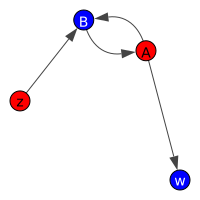

In [24]:
example3 = igraph.Graph(directed=True)
count = 0
for vertex in ["A", "B", "z", "w"]:
    example3.add_vertex(name=vertex, 
                       #label=(vertex if vertex in ("B", "A") else ""),
                       label=vertex,
                       type=count%2, 
                       color=("blue" if count%2 else "red"), 
                       label_color=("white" if count%2 else "black"))
    count += 1
    
example3.add_edges([('A', 'B'), ('B', 'A'), ("A", "w"), ("z", "B")])

igraph.drawing.plot(example3, bbox=(200, 200), target="output3.pdf")

IGRAPH DN-T 4 4 -- 
+ attr: color (v), label (v), label_color (v), name (v), type (v)
Bipartite: True
0 A A
1 B B
2 z z
3 w w

IGRAPH DN-- 2 2 -- 
+ attr: label (v), name (v)


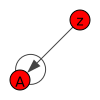

In [25]:
print(example3.summary())
print("Bipartite:", example3.is_bipartite())

for v in example3.vs:
    print(v.index, v["name"], v["label"])
print()

collapsed_example3 = collapse(example3, False)
print(collapsed_example3.summary())
igraph.drawing.plot(collapsed_example3, bbox=(100, 100), target="output4.pdf")